In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [21]:
cols = ["X", "Y", "month", "day", "FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain", "area"]
df = pd.read_csv("forestfires.csv", names=cols, header=0)
# Add the header=0 parameter to skip the first row of the CSV file:
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


TODO:

- day month mapping
- log exp transform
- All features
- Only weather features (temp, RH, wind, rain)
- Other logical groupings (e.g., FWI components: FFMC, DMC, DC, ISI)

In [22]:
print(df['month'].unique(),
 df['day'].unique())

['mar' 'oct' 'aug' 'sep' 'apr' 'jun' 'jul' 'feb' 'jan' 'dec' 'may' 'nov'] ['fri' 'tue' 'sat' 'sun' 'mon' 'wed' 'thu']


In [23]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  return data, X, y

In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [25]:
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

day_mapping = {'sun': 1, 'mon': 2, 'tue': 3, 'wed': 4, 'thu': 5, 'fri': 6, 'sat': 7}

df['month'] = df['month'].map(month_mapping)
df['day'] = df['day'].map(day_mapping)
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,6,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,10,3,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,10,7,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,3,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,3,1,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,8,1,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,8,1,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,8,1,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,8,7,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [26]:
# Create cyclical features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 7)
df = df.drop(['month', 'day'], axis='columns')
df

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,month_sin,month_cos,day_sin,day_cos
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,1.000000,6.123234e-17,-7.818315e-01,0.623490
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,-0.866025,5.000000e-01,4.338837e-01,-0.900969
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,-0.866025,5.000000e-01,-2.449294e-16,1.000000
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,1.000000,6.123234e-17,-7.818315e-01,0.623490
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,1.000000,6.123234e-17,7.818315e-01,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,-0.866025,-5.000000e-01,7.818315e-01,0.623490
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,-0.866025,-5.000000e-01,7.818315e-01,0.623490
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,-0.866025,-5.000000e-01,7.818315e-01,0.623490
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,-0.866025,-5.000000e-01,-2.449294e-16,1.000000


For Month Features (month_sin and month_cos):

```month_sin```: Represents the vertical position (y-coordinate) on a unit circle
```month_cos```: Represents the horizontal position (x-coordinate) on a unit circle

For example:

January (month 1): sin ≈ 0.5, cos ≈ 0.87
July (month 7): sin ≈ -0.5, cos ≈ -0.87

For Day Features (day_sin and day_cos):

```day_sin```: Represents the vertical position (y-coordinate) on a unit circle
```day_cos```: Represents the horizontal position (x-coordinate) on a unit circle

For example:

Monday (day 1): sin ≈ 0.78, cos ≈ 0.62

Thursday (day 4): sin ≈ -0.43, cos ≈ -0.9

Fire risk often follows seasonal patterns that are cyclical in nature
This preserves the ordinal relationship between adjacent months/days
It captures the circular nature of time (December is close to January)
It's more compact than one-hot encoding (2 features per variable instead of 7 or 12)

In [27]:
# logarithm prepocessing the Area target

# 1. Apply logarithmic transformation to the target variable
df['log_area'] = np.log1p(df['area'])  # log1p is ln(x+1)
df = df.drop(['area'], axis='columns')
df

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_sin,month_cos,day_sin,day_cos,log_area
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1.000000,6.123234e-17,-7.818315e-01,0.623490,0.000000
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,-0.866025,5.000000e-01,4.338837e-01,-0.900969,0.000000
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,-0.866025,5.000000e-01,-2.449294e-16,1.000000,0.000000
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1.000000,6.123234e-17,-7.818315e-01,0.623490,0.000000
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,1.000000,6.123234e-17,7.818315e-01,0.623490,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,-0.866025,-5.000000e-01,7.818315e-01,0.623490,2.006871
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,-0.866025,-5.000000e-01,7.818315e-01,0.623490,4.012592
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,-0.866025,-5.000000e-01,7.818315e-01,0.623490,2.498152
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,-0.866025,-5.000000e-01,-2.449294e-16,1.000000,0.000000


In [28]:
# 2. Create a subset with only the four weather variables that performed best
weather_features = ['temp', 'RH', 'wind', 'rain']
df_weather = df[weather_features + ['log_area']]


# For example, after getting predictions:
# actual_predictions = np.expm1(log_predictions)  # expm1 is exp(x)-1

df_weather

,temp,RH,wind,rain,log_area
0,8.2,51,6.7,0.0,0.000000
1,18.0,33,0.9,0.0,0.000000
2,14.6,33,1.3,0.0,0.000000
3,8.3,97,4.0,0.2,0.000000
4,11.4,99,1.8,0.0,0.000000
...,...,...,...,...,...
512,27.8,32,2.7,0.0,2.006871
513,21.9,71,5.8,0.0,4.012592
514,21.2,70,6.7,0.0,2.498152
515,25.6,42,4.0,0.0,0.000000


In [29]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
print(len(train), len(val), len(test))

310 103 104


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Your instinct to preprocess data after splitting is generally correct for transformations that learn parameters from the data. Examples include:

Scaling (like StandardScaler or MinMaxScaler): These fit to the training data to calculate means/variances or min/max values, which are then used to transform the training, validation, and test sets. Fitting on the whole dataset before splitting would leak information about the distribution of the validation and test sets into the training process, leading to overly optimistic performance estimates.
Dimensionality Reduction (like PCA): PCA learns the principal components from the training data.
However, the transformations you are applying here are stateless or deterministic transformations that do not learn parameters from the data:

Mapping month and day names to numbers: This is a fixed dictionary lookup.
Creating cyclical features (sin and cos): This is a fixed mathematical formula applied to the month and day numbers.
Applying np.log1p to the target variable: This is also a fixed mathematical function.
Applying these deterministic transformations before splitting the data does not introduce data leakage because the transformation itself does not depend on the specific values or distribution of the data in any of the splits. It applies the same rule to every data point regardless of whether it's in the train, validation, or test set.

In [30]:
_, X_train_all, y_train_all = get_xy(train, "log_area", x_labels=df.columns)
_, X_val_all, y_val_all = get_xy(val, "log_area", x_labels=df.columns)
_, X_test_all, y_test_all = get_xy(test, "log_area", x_labels=df.columns)

In [49]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(15,), axis=None)
all_normalizer.adapt(X_train_all.reshape(-1)) # normalize each column by column individually

In [50]:
all_nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(1)
])

1. ReLU (Rectified Linear Unit)

Formula: f(x) = max(0, x)
Description: It outputs the input directly if it's positive, otherwise, it outputs zero.
When to use:
Hidden layers: ReLU is currently the most popular choice for hidden layers in deep neural networks [1].
Why:
Computational efficiency: It's computationally simple to calculate.
Avoids vanishing gradients: Unlike sigmoid and tanh, ReLU does not saturate for positive values, which helps prevent the vanishing gradient problem during training, especially in deep networks.
Considerations:
Dying ReLU problem: Neurons can become "dead" if the input is always negative, resulting in a zero gradient and no learning.
2. Sigmoid (Logistic)

Formula: f(x) = 1 / (1 + e^-x)
Description: It squashes the input to a range between 0 and 1.
When to use:
Output layer for binary classification: Useful when you need an output that can be interpreted as a probability.
Why:
Outputs probabilities: The output is in the range [0, 1], which is suitable for representing probabilities.
Considerations:
Vanishing gradients: The gradient of the sigmoid function is very small for values far from zero, which can lead to the vanishing gradient problem in deep networks [1].
Output is not zero-centered: This can cause issues during training.
3. Tanh (Hyperbolic Tangent)

Formula: f(x) = (e^x - e^-x) / (e^x + e^-x)
Description: It squashes the input to a range between -1 and 1.
When to use:
Hidden layers (less common now than ReLU): It was a popular choice before ReLU became widespread.
Why:
Output is zero-centered: This can help with the training process compared to sigmoid.
Considerations:
Vanishing gradients: Similar to sigmoid, tanh also suffers from the vanishing gradient problem [1].
4. Swish

Formula: f(x) = x * sigmoid(x)
Description: It's a relatively newer activation function that has been shown to perform well in some cases.
When to use:
Deep networks (especially those with more than 40 layers): It can sometimes outperform ReLU in very deep networks [1].
Why:
Smooth and non-monotonic: These properties can help with optimization.
Considerations:
More computationally expensive than ReLU.

Complexity of the problem: More complex problems generally require deeper networks with more layers and/or more nodes per layer to capture intricate patterns.
Amount of data: With more data, you can train larger models without overfitting.
Computational resources: Training very deep and wide networks requires significant computational power.
Risk of overfitting: Too many layers or nodes can lead to overfitting, where the model performs well on the training data but poorly on unseen data.
Underfitting: Too few layers or nodes can lead to underfitting, where the model is too simple to capture the underlying patterns in the data.
Here's a general approach to determining the number of layers and nodes:

Start simple: Begin with a relatively simple architecture (e.g., one or two hidden layers with a moderate number of nodes).
Experiment and iterate: Train the model and evaluate its performance on a validation set. If the model is underfitting, consider adding more layers or increasing the number of nodes. If the model is overfitting, consider reducing the number of layers or nodes, adding regularization techniques, or increasing the amount of training data.
Consider the data's structure: Think about the nature of your data and the relationships you expect to find. This can provide clues about the appropriate network architecture.
Use established architectures as a starting point: For certain types of data (e.g., images, text), there are established neural network architectures (like CNNs for images or RNNs for text) that you can adapt to your problem.

In [51]:

all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

Mean Squared Error (MSE): This is a common loss function for regression problems. It calculates the average of the squared differences between the predicted values and the actual values. You used mean_squared_error in the code you provided.


Mean Absolute Error (MAE): Another loss function for regression. It calculates the average of the absolute differences between the predicted and actual values. MAE is less sensitive to outliers than MSE.


Binary Crossentropy: Used for binary classification problems. It measures the performance of a classification model whose output is a probability value between 0 and 1.


Categorical Crossentropy: Used for multi-class classification problems where the labels are one-hot encoded.
Sparse Categorical Crossentropy: Used for multi-class classification problems where the labels are integers.



Convergence Speed: A higher learning rate can lead to faster convergence initially, but if it's too high, it might oscillate around the minimum or even diverge. A lower learning rate will converge more slowly but might find a more precise minimum.
Finding the Minimum: The learning rate influences whether the optimization algorithm can find the global minimum or get stuck in a local minimum.
Choosing the Learning Rate

There's no universal rule to estimate the learning rate based solely on data size. However, here are some general guidelines and techniques:

Start with a reasonable default: Optimizers like Adam often have good default learning rates (e.g., 0.001). Starting with a value around this range is a good initial step.
Learning Rate Schedules: Instead of using a fixed learning rate, you can use a learning rate schedule that changes the learning rate during training. Common schedules include:
Step decay: Decrease the learning rate by a factor at specific epochs.
Exponential decay: Decrease the learning rate exponentially over time.
ReduceLROnPlateau: Reduce the learning rate when a metric (e.g., validation loss) stops improving.
Learning Rate Finder: A technique to find a good initial learning rate is the learning rate finder. It involves training the model for a few epochs with a very low learning rate that gradually increases. You then plot the loss against the learning rate and look for the point where the loss starts to decrease rapidly. This point can suggest a good learning rate to start with.
Experimentation and Validation: The best way to find a good learning rate is through experimentation. Train your model with different learning rates and evaluate their performance on the validation set. The learning rate that gives the best performance on the validation set is likely a good choice.
Relationship with Data Size

While there's no direct formula, here's how data size can indirectly influence learning rate considerations:

Larger datasets: With larger datasets, you might be able to use a slightly higher learning rate initially because the gradient updates will be more stable due to averaging over more data points. However, you still need to be cautious about overshooting.
Smaller datasets: With smaller datasets, you might need to use a smaller learning rate or a more aggressive learning rate schedule to avoid overfitting. A high learning rate with a small dataset can easily lead to the model memorizing the training data instead of learning general patterns.

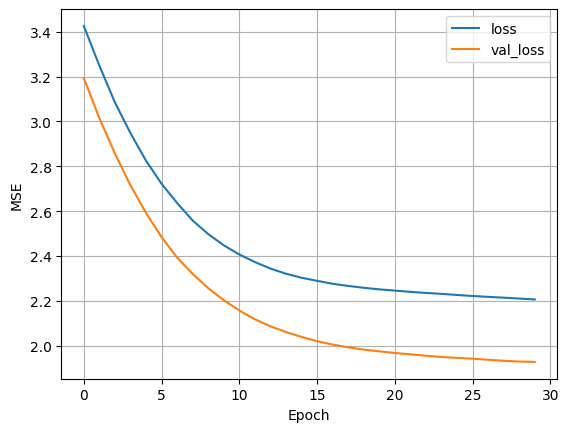

In [52]:
history = all_nn_model.fit(
    X_train_all, y_train_all,
    verbose=0,
    epochs=30,
    validation_data=(X_val_all, y_val_all),

)
plot_loss(history)
  # underfitting try  this to bike dataset(multifeature training as well) and work perfectly fine
  # so problem is the difference of datasets this seem to be underfitting?, since there're like 800 rows
  # but why loss started so low?, oversampling?

In [35]:
#plot_loss(history)

In [57]:
df['Area_invereselog'] = np.expm1(df['log_area'])
df

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_sin,month_cos,day_sin,day_cos,log_area,Area_invereselog
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1.000000,6.123234e-17,-7.818315e-01,0.623490,0.000000,0.00
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,-0.866025,5.000000e-01,4.338837e-01,-0.900969,0.000000,0.00
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,-0.866025,5.000000e-01,-2.449294e-16,1.000000,0.000000,0.00
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1.000000,6.123234e-17,-7.818315e-01,0.623490,0.000000,0.00
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,1.000000,6.123234e-17,7.818315e-01,0.623490,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,-0.866025,-5.000000e-01,7.818315e-01,0.623490,2.006871,6.44
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,-0.866025,-5.000000e-01,7.818315e-01,0.623490,4.012592,54.29
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,-0.866025,-5.000000e-01,7.818315e-01,0.623490,2.498152,11.16
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,-0.866025,-5.000000e-01,-2.449294e-16,1.000000,0.000000,0.00


In [60]:
print(df['Area_invereselog'].max(), df['Area_invereselog'].min())
print(df['wind'].max(), df['wind'].min())

1090.8400000000004 0.0
9.4 0.4


In [36]:
df['log_area'].value_counts()


,count
log_area,
0.000000,247
1.078410,3
0.357674,2
0.900161,2
1.081805,2
...,...
1.916923,1
1.153732,1
2.006871,1


In [37]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)
# now its train_all

LinearRegression()

In [38]:
all_reg.score(X_test_all, y_test_all)


1.0

In [39]:
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = all_nn_model.predict(X_test_all)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [40]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [41]:
MSE(y_pred_lr, y_test_all)

np.float64(1.7087108650289278e-29)

In [42]:
MSE(y_pred_nn, y_test_all)

np.float64(3.445089680831504)